# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# The main answer of this study is: How to improve the Starbucks offer strategy? For this reason offer completion rate will be the main metric of interest.


## This work book is split into 6 main parts:
- Data cleaning
- Exploratory data analysis
- Data transformation
- Data analysis
- Main takeaways from data analysis
- Data modelling
- Conclusion
- Improvements

## 1. Clean customer profile and transcript data

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [5]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [6]:
(profile.gender.isnull() & profile.income.isnull()).sum()

2175

In [7]:
profile[profile.gender.isnull()].age.unique()

array([118])

In [8]:
## list of person ids  that have no information about gender and income
remove_idx=profile[profile.gender.isnull()].id
## remove the rows which have no information about gender
profile.drop(profile[profile.gender.isnull()].index, inplace=True)
transcript = transcript[~transcript.person.isin(remove_idx)]
## reset index
profile.reset_index(drop=True,inplace=True)
transcript.reset_index(drop=True,inplace=True)

In [9]:
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.rename(columns={'id':'person'},inplace=True)


In [10]:
profile.head()

,gender,age,person,became_member_on,income
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


## 2. Exploratory data analysis
- Check the age distribution of customers
- Check the gender proportion of the customer
- Check the income distribution of the customer
- Check the income vs age distribution
- Check the offer table

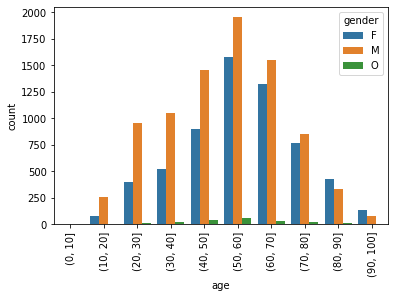

(None, 55.0, 54.39352445193929)

In [11]:
bins= [0,10,20,30,40,50,60,70,80,90,100]
x_year = pd.cut(profile.age, bins=bins)
sns.countplot(data= profile,x=x_year,hue=profile.gender)
plt.xticks(rotation=90)
plt.show(), profile.age.median(),profile.age.mean()

In [12]:
### gender proportion
profile.gender.value_counts()/profile.gender.count()

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

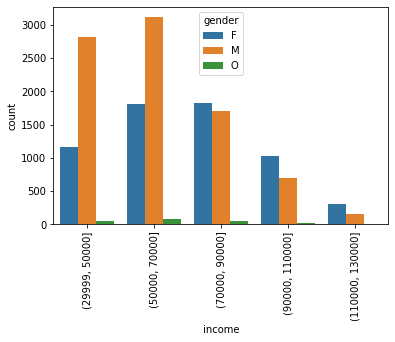

(None, 64000.0, 65404.9915682968)

In [13]:
bins = [29999,50000,70000,90000,110000,130000]
x_income = pd.cut(profile.income, bins=bins)
sns.countplot(data= profile,x=x_income,hue=profile.gender)
plt.xticks(rotation=90)
plt.show(),profile.income.median(),profile.income.mean()

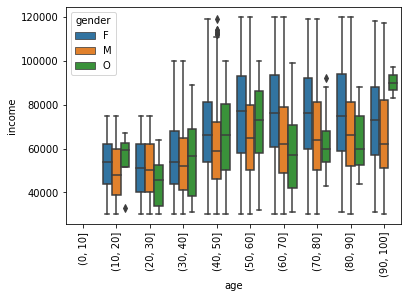

In [14]:
sns.boxplot(data= profile,x=x_year,y=profile.income,hue=profile.gender)
plt.xticks(rotation=90)
plt.show()

In [15]:
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

### Main insights from following analysis:
- Age distribution is symmetrical
- Median/average age of the customer is 55 years
- More than half of the customers are males (57.2%)
- Income distribution has right-skewed distribution
- Median/average income of the customer is 64 000/ 65 000 USD
- Females have higher median income than males across all age groups
- 4 discount, 4 bogo (buy one get one free) and 2 informational offers


## 3. Data transformation
- Make a reward table by transforming transcript table and unpacking value column
- Build a table which shows events per user_id
- Make a table which shows total events,awards per user_id 

In [16]:
reward_table=pd.json_normalize(transcript.value)
reward_table.head()

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
2,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
3,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


In [17]:
## Merge offer id and offer_id columns since they contain similar information 
reward_table['offer_id'].fillna(reward_table['offer id'],inplace=True)
reward_table.drop(columns='offer id',inplace=True)
reward_table.head()

,amount,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
2,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,NaN,3f207df678b143eea3cee63160fa8bed,NaN
4,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [18]:
ext_transcript=pd.concat([transcript,reward_table],axis=1)
ext_transcript.head()

,person,event,value,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
2,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,NaN,3f207df678b143eea3cee63160fa8bed,NaN
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN


In [19]:
### make table with person id as an index and double collumn index (1st-layer offer_id, 2nd layer outcome)
offer_stats = ext_transcript.groupby(by=['person','offer_id','event']).value.count().unstack(level=[1,2])
offer_stats.head()

offer_id                         2906b810c7d4411798c6938adc9daaa5  \
event                                             offer completed   
person                                                              
0009655768c64bdeb2e877511632db8f                              1.0   
0011e0d4e6b944f998e987f904e8c1e5                              NaN   
0020c2b971eb4e9188eac86d93036a77                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                              NaN   
003d66b6608740288d6cc97a6903f4f0                              NaN   

offer_id                                         \
event                            offer received   
person                                            
0009655768c64bdeb2e877511632db8f            1.0   
0011e0d4e6b944f998e987f904e8c1e5            NaN   
0020c2b971eb4e9188eac86d93036a77            NaN   
0020ccbbb6d84e358d3414a3ff76cffd            NaN   
003d66b6608740288d6cc97a6903f4f0            NaN   

offer_id                         3f207df678b143eea3cee63160fa8bed  \
event                                              offer received   
person                                                              
0009655768c64bdeb2e877511632db8f                              1.0   
0011e0d4e6b944f998e987f904e8c1e5                              1.0   
0020c2b971eb4e9188eac86d93036a77                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                              NaN   
003d66b6608740288d6cc97a6903f4f0                              1.0   

offer_id                                       \
event                            offer viewed   
person                                          
0009655768c64bdeb2e877511632db8f          1.0   
0011e0d4e6b944f998e987f904e8c1e5          1.0   
0020c2b971eb4e9188eac86d93036a77          NaN   
0020ccbbb6d84e358d3414a3ff76cffd          NaN   
003d66b6608740288d6cc97a6903f4f0          1.0   

offer_id                         5a8bc65990b245e5a138643cd4eb9837  \
event                                              offer received   
person                                                              
0009655768c64bdeb2e877511632db8f                              1.0   
0011e0d4e6b944f998e987f904e8c1e5                              1.0   
0020c2b971eb4e9188eac86d93036a77                              1.0   
0020ccbbb6d84e358d3414a3ff76cffd                              1.0   
003d66b6608740288d6cc97a6903f4f0                              1.0   

offer_id                                       \
event                            offer viewed   
person                                          
0009655768c64bdeb2e877511632db8f          1.0   
0011e0d4e6b944f998e987f904e8c1e5          1.0   
0020c2b971eb4e9188eac86d93036a77          1.0   
0020ccbbb6d84e358d3414a3ff76cffd          1.0   
003d66b6608740288d6cc97a6903f4f0          1.0   

offer_id                         f19421c1d4aa40978ebb69ca19b0e20d  \
event                                             offer completed   
person                                                              
0009655768c64bdeb2e877511632db8f                              1.0   
0011e0d4e6b944f998e987f904e8c1e5                              NaN   
0020c2b971eb4e9188eac86d93036a77                              NaN   
0020ccbbb6d84e358d3414a3ff76cffd                              1.0   
003d66b6608740288d6cc97a6903f4f0                              NaN   

offer_id                                                      \
event                            offer received offer viewed   
person                                                         
0009655768c64bdeb2e877511632db8f            1.0          1.0   
0011e0d4e6b944f998e987f904e8c1e5            NaN          NaN   
0020c2b971eb4e9188eac86d93036a77            NaN          NaN   
0020ccbbb6d84e358d3414a3ff76cffd            1.0          1.0   
003d66b6608740288d6cc97a6903f4f0            NaN          NaN   

offer_id                         fafdcd668e3743c1bb461111dcafc2a4  ...  \
event 

In [20]:
totals_per_id = transcript.groupby(by=['event','person']).value.count().unstack(level=0)
totals_per_id.fillna(0,inplace=True)
#events_per_id['cmplt rate'] = events_per_id['offer completed']/events_per_id['offer received']
#events_per_id['view rate'] = events_per_id['offer viewed']/events_per_id['offer received']
totals_per_id=pd.concat([totals_per_id,ext_transcript.groupby('person')[['amount','reward']].sum()],axis=1)
totals_per_id.head()

,offer completed,offer received,offer viewed,transaction,amount,reward
person,,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,127.60,9.0
0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,5.0,79.46,13.0
0020c2b971eb4e9188eac86d93036a77,3.0,5.0,3.0,8.0,196.86,14.0
0020ccbbb6d84e358d3414a3ff76cffd,3.0,4.0,4.0,12.0,154.05,13.0
003d66b6608740288d6cc97a6903f4f0,3.0,5.0,4.0,18.0,48.34,9.0


## 4. Further data analysis
- How age correlates with the amount of spent money?
- How age correlates with the amount of received rewards?
- How income correlates with the amount of spent money?
- How income correlates with the ammount of received rewards?
- Which of the income and age groups spend the most money?
- Which way of communication/advertisement is the most effective?
- Which offers have the highest view/completion rate? Does it correlate with offer type, reward, difficulty or duration?
- Is there any dependence of offer completion on the customer gender,age,income ?

In [21]:
def sorting(user_info,totals_offers,param):

    df1 = user_info.set_index('person')
    
    df1 = df1[['age','gender','income']]
    
    result = pd.merge(df1,totals_offers,left_index=True,right_index=True)
    
    if param[0] == 'age':
        
        bins= [0,10,20,30,40,50,60,70,80,90,100]
        
        result['age group'] = pd.cut(result.age, bins=bins)
        
        sns.boxplot(data=result,x=result['age group'],y=param[1],hue=param[2])
        
        
    elif param[0] == 'income':
        
        bins = [29999,50000,70000,90000,110000,130000]
        
        result['income group'] = pd.cut(result.income, bins=bins)
        
        sns.boxplot(data=result,x=result['income group'],y=param[1],hue=param[2])
    

### 4.1 Spent money vs age

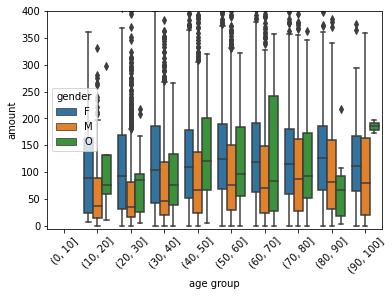

In [22]:
sorting(profile,totals_per_id,['age','amount','gender'])
plt.xticks(rotation=45)
plt.ylim(-5,400)
plt.show()


- #### In all the age groups the median value of spent money is higher for females than males.
- #### The median of spent money is in the range of 20-130 USD
- #### The most spending group is of the 50-60 age

### 4.2 Rewards vs age

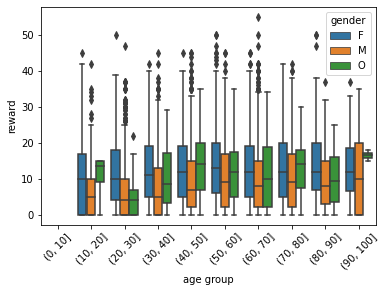

In [23]:
sorting(profile,totals_per_id,['age','reward','gender'])
plt.xticks(rotation=45)
plt.show()



- #### In all the age groups the median reward value is higher for females.
- #### Median value of rewards is in the range 5-15 USD

### 4.3 Spent money vs income

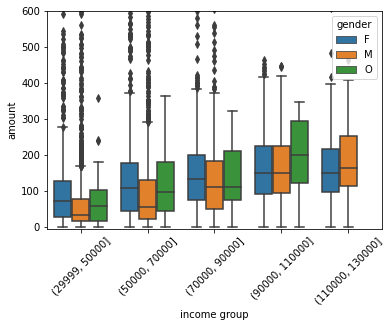

In [24]:
sorting(profile,totals_per_id,['income','amount','gender'])
plt.xticks(rotation=45)
plt.ylim(-5,600)
plt.show()


- #### Amount of money spent increases with income group
- #### Media amount of money spent is in the range of 50-150 USD

### 4.4 Rewards vs income group

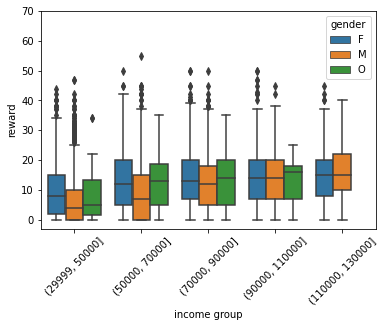

In [25]:
sorting(profile,totals_per_id,['income','reward','gender'])
plt.xticks(rotation=45)
plt.ylim(-3,70)
plt.show()

- #### Median value of rewards increases with the income group

### 4.5 Which of the income and age groups spend the most ?

In [26]:
def spend_stats(user_info,user_offers,param):

    df1 = user_info.set_index('person')
    
    df1 = df1[['age','gender','income']]
    
    result = pd.merge(df1,user_offers,left_index=True,right_index=True)
    
    result['age group'] = pd.cut(result.age, bins= [0,10,20,30,40,50,60,70,80,90,100])
    
    result['income group'] = pd.cut(result.income, bins= [30000,50000,70000,90000,110000,130000])
    
    if param =='age':
        
        result=result.groupby('age group')[['amount','reward']].sum()
        
        
    elif param =='income':
        
        result=result.groupby('income group')[['amount','reward']].sum()
        
    result['amount']=result['amount']/result['amount'].sum()
        
    return result['amount'].sort_values(ascending=False)
    

In [27]:
spend_stats(profile,totals_per_id,'age')

age group
(50, 60]     0.263112
(60, 70]     0.211254
(40, 50]     0.151787
(70, 80]     0.121395
(30, 40]     0.093713
(20, 30]     0.068767
(80, 90]     0.059221
(90, 100]    0.015919
(10, 20]     0.014831
(0, 10]      0.000000
Name: amount, dtype: float64

- ####  More than for 40 % (~ 47 %) of Starbuck's revenue was recieved from 50-70 years old people.
- ####  Young people 10-30 years old only constitute ~8.2 % of total revenue.

In [28]:
spend_stats(profile,totals_per_id,'income')

income group
(70000, 90000]      0.305566
(50000, 70000]      0.303771
(90000, 110000]     0.184412
(30000, 50000]      0.156609
(110000, 130000]    0.049642
Name: amount, dtype: float64

- #### More than 60 % of revenue was acquired from people having annual income of 50 000 - 90 0000 USD
- #### Less that 5 % of revenue came from the group with 110 000 - 130 000 USD income

 ### 4.6 Which way of communication/advertisement is the most effective?

In [29]:
def portfolio_stats (prom_db,offers_db):
    
    db1 = prom_db.set_index('id')
    
    offers_sum = pd.DataFrame(offers_db.sum())
    
    db2 = pd.pivot_table(offers_sum, values=0, index=offers_sum.index.get_level_values(0),
                    columns=offers_sum.index.get_level_values(1))
    
    db2['cmplt rate']=db2['offer completed']/db2['offer received']
    
    db2['view rate']=db2['offer viewed']/db2['offer received']
    
    
    result = pd.merge(db1,db2,left_index=True,right_index=True)
    
    result['offer no'] = ([list(portfolio.id).index(i) for i in result.index])
    
    #return result.sort_values(by=parameter,ascending=False)
    return result

In [30]:
portfolio_stats(portfolio,offer_stats)


,reward,channels,difficulty,duration,offer_type,offer completed,offer received,offer viewed,cmplt rate,view rate,offer no
ae264e3637204a6fb9bb56bc8210ddfd,10,"[email, mobile, social]",10,7,bogo,3657.0,6683.0,5901.0,0.547209,0.882987,0
4d5c57ea9a6940dd891ad53e9dbe8da0,10,"[web, email, mobile, social]",10,5,bogo,3310.0,6593.0,6329.0,0.502048,0.959958,1
3f207df678b143eea3cee63160fa8bed,0,"[web, email, mobile]",0,4,informational,NaN,6657.0,3487.0,NaN,0.523810,2
9b98b8c7a33c4b65b9aebfe6a799e6d9,5,"[web, email, mobile]",5,7,bogo,4188.0,6685.0,3499.0,0.626477,0.523411,3
0b1e1539f2cc45b7b9fa7c272da2e1d7,5,"[web, email]",20,10,discount,3386.0,6726.0,2215.0,0.503420,0.329319,4
2298d6c36e964ae4a3e7e9706d1fb8c2,3,"[web, email, mobile, social]",7,7,discount,4886.0,6655.0,6379.0,0.734185,0.958527,5
fafdcd668e3743c1bb461111dcafc2a4,2,"[web, email, mobile, social]",10,10,discount,5003.0,6652.0,6407.0,0.752105,0.963169,6
5a8bc65990b245e5a138643cd4eb9837,0,"[email, mobile, social]",0,3,informational,NaN,6643.0,5873.0,NaN,0.884089,7
f19421c1d4aa40978ebb69ca19b0e20d,5,"[web, email, mobile, social]",5,5,bogo,4103.0,6576.0,6310.0,0.623936,0.959550,8
2906b810c7d4411798c6938adc9daaa5,2,"[web, email, mobile]",10,7,discount,3911.0,6631.0,3460.0,0.589805,0.521792,9


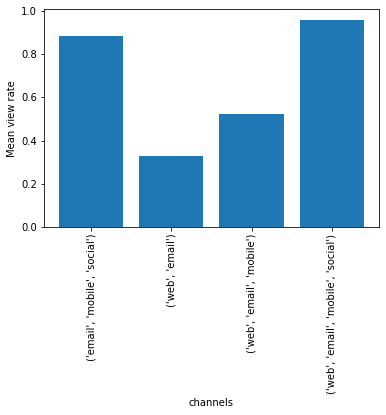

In [31]:
def stats_graph(x, view_param, mean=True):
    
    db = portfolio_stats(portfolio,offer_stats)
    
    if x == 'channels':
        if mean:
            result = db.groupby(db[x].map(tuple)).mean()

            plt.bar([str(i) for i in result.index],result[view_param])

            plt.xticks(rotation=90)

            plt.ylabel('Mean ' + view_param)
            
            plt.xlabel(x)

            plt.plot()
            
        else:
            result = db.groupby(db[x].map(tuple)).median()

            plt.bar([str(i) for i in result.index],result[view_param])

            plt.xticks(rotation=90)

            plt.ylabel('Median ' + view_param)
            
            plt.xlabel(x)

            plt.plot()

    else:
        
        if mean:
            result = db.groupby(db[x]).mean()

            plt.bar([str(i) for i in result.index],result[view_param])

            plt.xticks(rotation=90)

            plt.ylabel('Mean ' + view_param)
            
            plt.xlabel(x)

            plt.plot()
        else:
            result = db.groupby(db[x]).median()

            plt.bar([str(i) for i in result.index],result[view_param])

            plt.xticks(rotation=90)

            plt.ylabel('Median ' + view_param)
            
            plt.xlabel(x)

            plt.plot()

        
    
stats_graph('channels','view rate',True)   

 - #### Promotions dissemenitated through web, email and mobile only reaced every second targeted customer.
 - #### View rate increases above 80% when social channel is used

### 4.7 Which offers were sent to customer the most times?

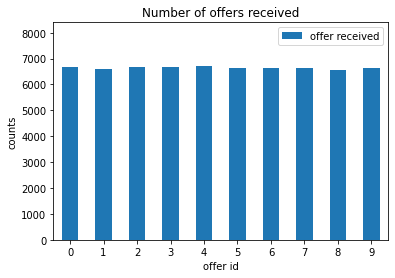

In [32]:
portfolio_stats(portfolio,offer_stats).plot.bar(x='offer no',y='offer received')
plt.xlabel('offer id')
plt.xticks(rotation=0)
plt.ylim(0,8400)
plt.ylabel('counts')
plt.title('Number of offers received')
plt.show()

In [33]:
portfolio_stats(portfolio,offer_stats)[['offer no','offer received']]

,offer no,offer received
ae264e3637204a6fb9bb56bc8210ddfd,0,6683.0
4d5c57ea9a6940dd891ad53e9dbe8da0,1,6593.0
3f207df678b143eea3cee63160fa8bed,2,6657.0
9b98b8c7a33c4b65b9aebfe6a799e6d9,3,6685.0
0b1e1539f2cc45b7b9fa7c272da2e1d7,4,6726.0
2298d6c36e964ae4a3e7e9706d1fb8c2,5,6655.0
fafdcd668e3743c1bb461111dcafc2a4,6,6652.0
5a8bc65990b245e5a138643cd4eb9837,7,6643.0
f19421c1d4aa40978ebb69ca19b0e20d,8,6576.0
2906b810c7d4411798c6938adc9daaa5,9,6631.0


- #### There is no sigficant difference in the number of sent offers 

### 4.7 What is distirbution of completion rate between offers?

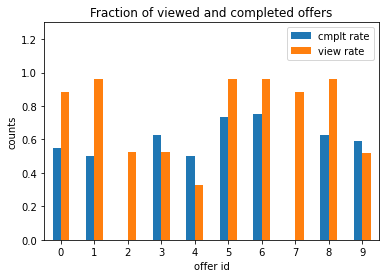

In [34]:
portfolio_stats(portfolio,offer_stats).plot.bar(x='offer no',y=['cmplt rate','view rate'])
plt.xlabel('offer id')
plt.xticks(rotation=0)
plt.ylim(0,1.3)
plt.ylabel('counts')
plt.title('Fraction of viewed and completed offers')
plt.show()

### 4.8 Which offers have the highest view/completion rate? Does it correlate with offer type, reward, difficulty or duration?

#### 4.8.1 Offer type

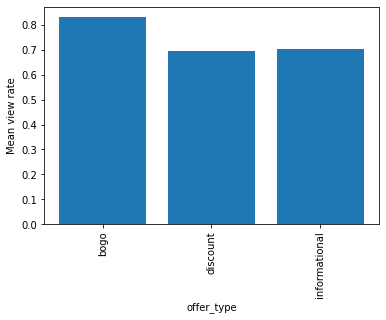

In [35]:
stats_graph('offer_type','view rate')

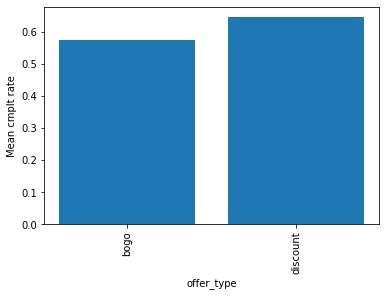

In [36]:
stats_graph('offer_type','cmplt rate')

- #### Bogo type offers are the most viewed (rate > 80 %), whereas discount and informational have ~70% view rate.
- #### Completion is higher for discount type offers (> 60%), while slightly below 60 % of bogo offers are completed.

#### 4.8.2 Reward

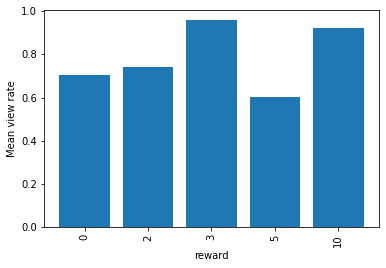

In [37]:
stats_graph('reward','view rate')

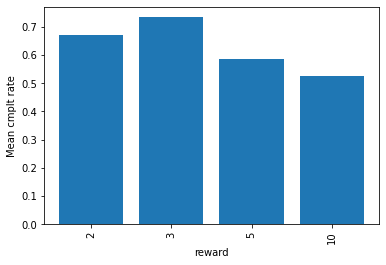

In [38]:
stats_graph('reward','cmplt rate')

- #### There is no clear correlation between reward and view rate.
- #### Completion rate is higher for 2-3 USD rewards (> 65 %) than for 5-10 USD rewards (< 60 %). 

#### 4.8.3 Difficulty

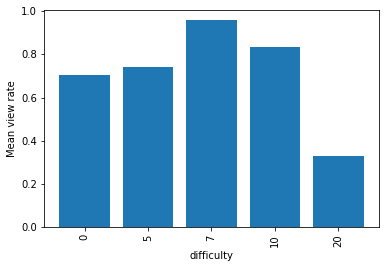

In [39]:
stats_graph('difficulty','view rate')

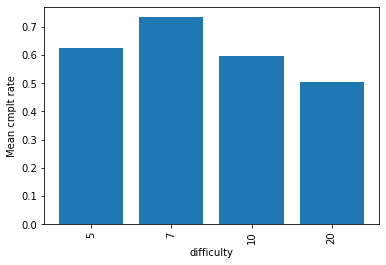

In [40]:
stats_graph('difficulty','cmplt rate')

- #### View rate is the lowest for the most difficult offer (20 USD), while the remaining ones the view rate is at least twice as big (~60 %)
- #### Completion rate varies from ~50% (20 USD difficulty) to ~70% (7 USD difficulty) 

#### 4.8.4 Duration

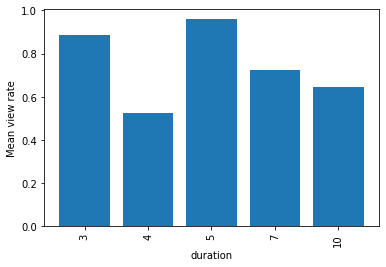

In [41]:
stats_graph('duration','view rate')

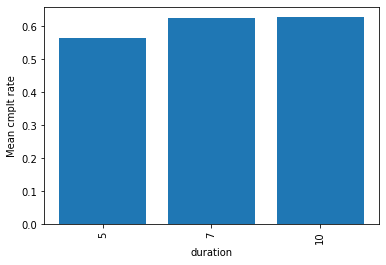

In [42]:
stats_graph('duration','cmplt rate')

- #### View rare does not depend on the offer duration, since the highest view rate is recorded for 3 and 5 day offers
- #### Completion rate does not strongly depend on the duration of the offer.

### 4.9 Is there any dependence of offer completion on the customer gender,age,income ?

In [43]:
### Shortening the names of columns 
new_columns=[]
for i in offer_stats.columns:
    x=list(i)
    x[0]=(list(portfolio.id).index(i[0]))
    if x[1] == 'offer completed': x[1]='cmpl'
    elif x[1] == 'offer received': x[1]='recv'
    elif x[1] == 'offer viewed': x[1]='view'    
    new_columns.append(tuple(x))   
offer_stats.columns=new_columns
offer_stats= offer_stats.reindex(sorted(offer_stats.columns), axis=1)

In [44]:
"""
db1 - customer information
db2 - offer information
offer - offer id (int)
param - parameter (income,age)
gender - Female, Male
"""
def customer_profile_stats (db1,db2,offer,param,gender):
    ## prepare first table for merge
    
    customers = db1.set_index('person')
    customers = customers[['age','gender','income']]
    customers['age'] = pd.cut(customers.age, bins=[10,20,30,40,50,60,70,80,90,100,110])
    customers['income']=pd.cut(customers.income, bins = [29999,50000,70000,90000,110000,130000])
    
    ## merge two tables
    
    result=pd.merge(customers,db2,left_index=True,right_index=True)
    
    ## select gender
    
    result = result[result.gender == gender]
    
    ## group by selected parameter
    
    result = result.groupby(by=param).sum()
        
        
    ## select the offer 
    
    off_filter = []
    
    for i in result.columns:
        
        if i[0] == offer:
            off_filter.append(i)
            
    off_filter.sort()
    
    result=result[off_filter]
        
    return result.div(result[(offer,'recv')],axis=0)*100

    

#### 4.9.1 Female: age vs completion/view rate

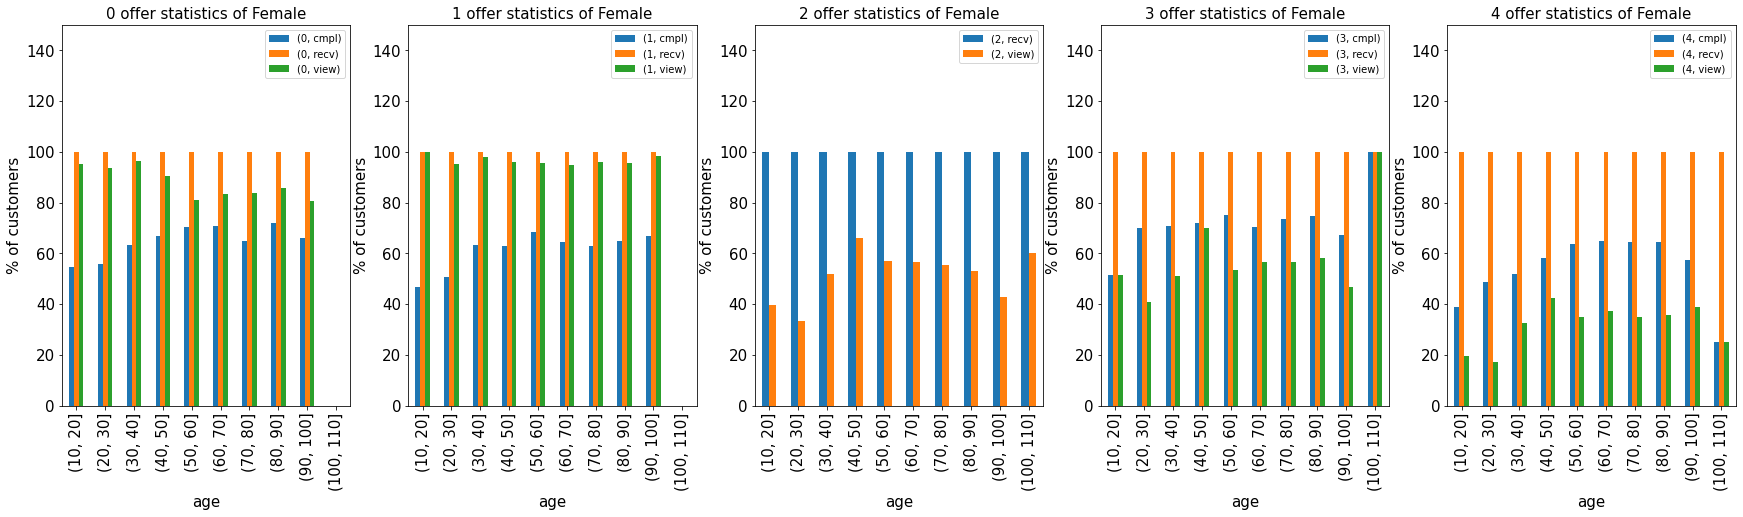

In [45]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i)+' offer statistics of Female',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i,['age'],'F').plot.bar(rot=90,ax=ax)


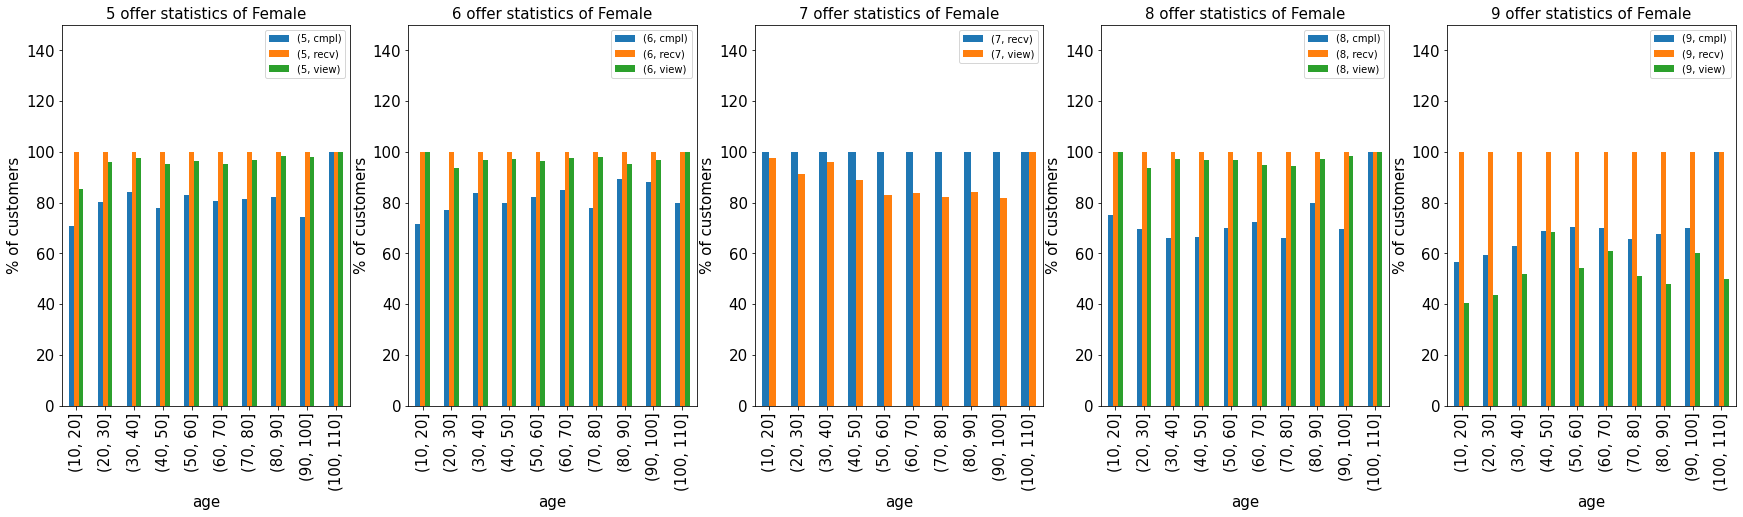

In [46]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i+5)+' offer statistics of Female',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i+5,['age'],'F').plot.bar(rot=90,ax=ax)


#### 4.9.2 Male: age vs completion/view rate

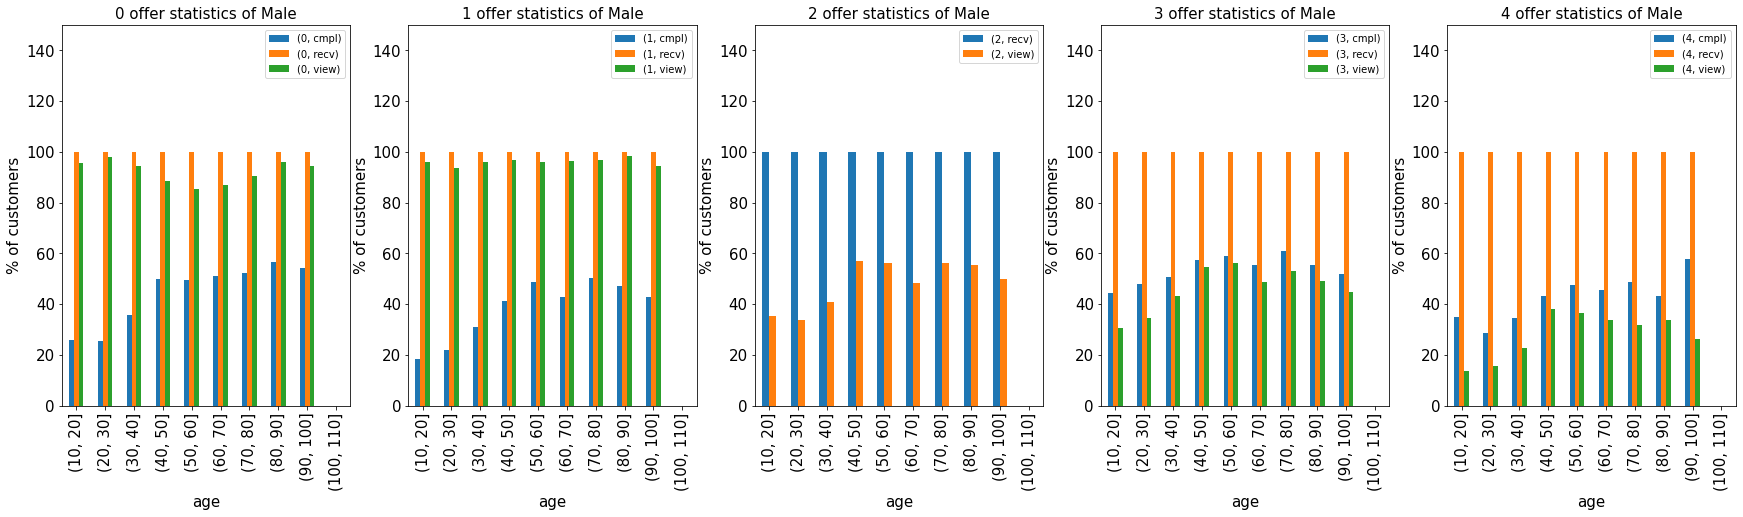

In [47]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i)+' offer statistics of Male',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i,['age'],'M').plot.bar(rot=90,ax=ax)


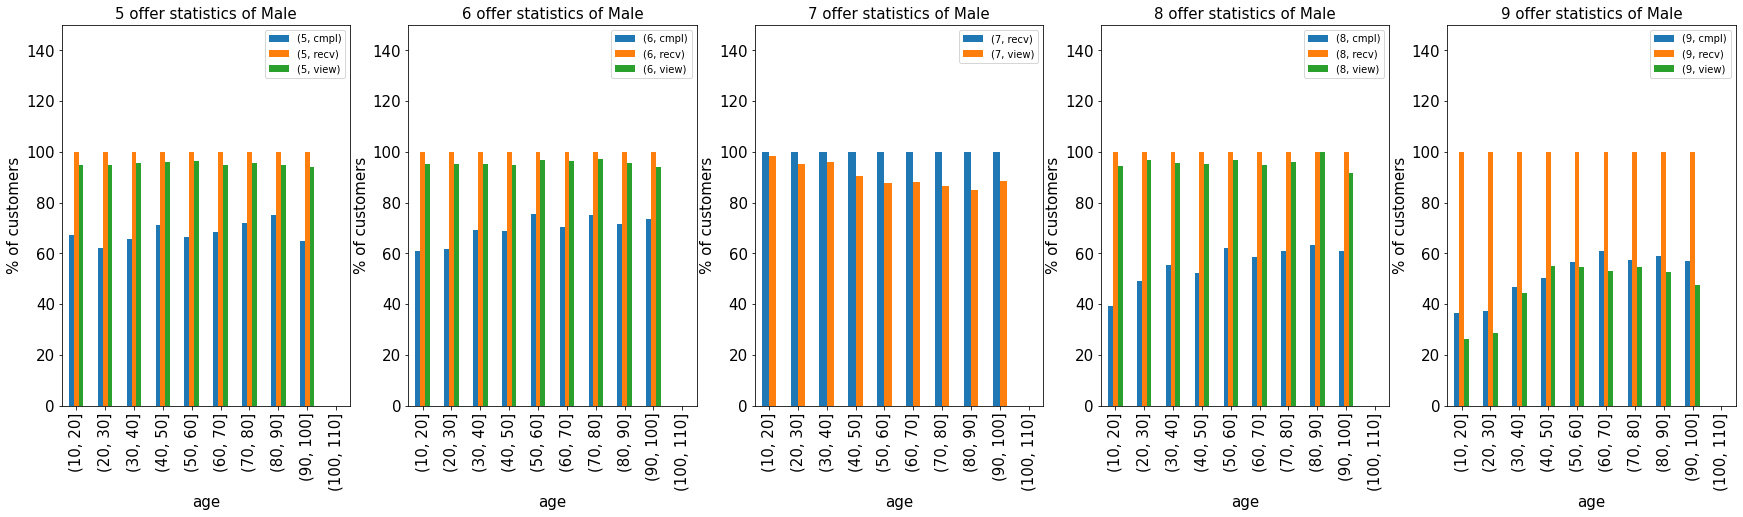

In [48]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i+5)+' offer statistics of Male',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i+5,['age'],'M').plot.bar(rot=90,ax=ax)


#### 4.9.3 Female: income vs completion/view rate

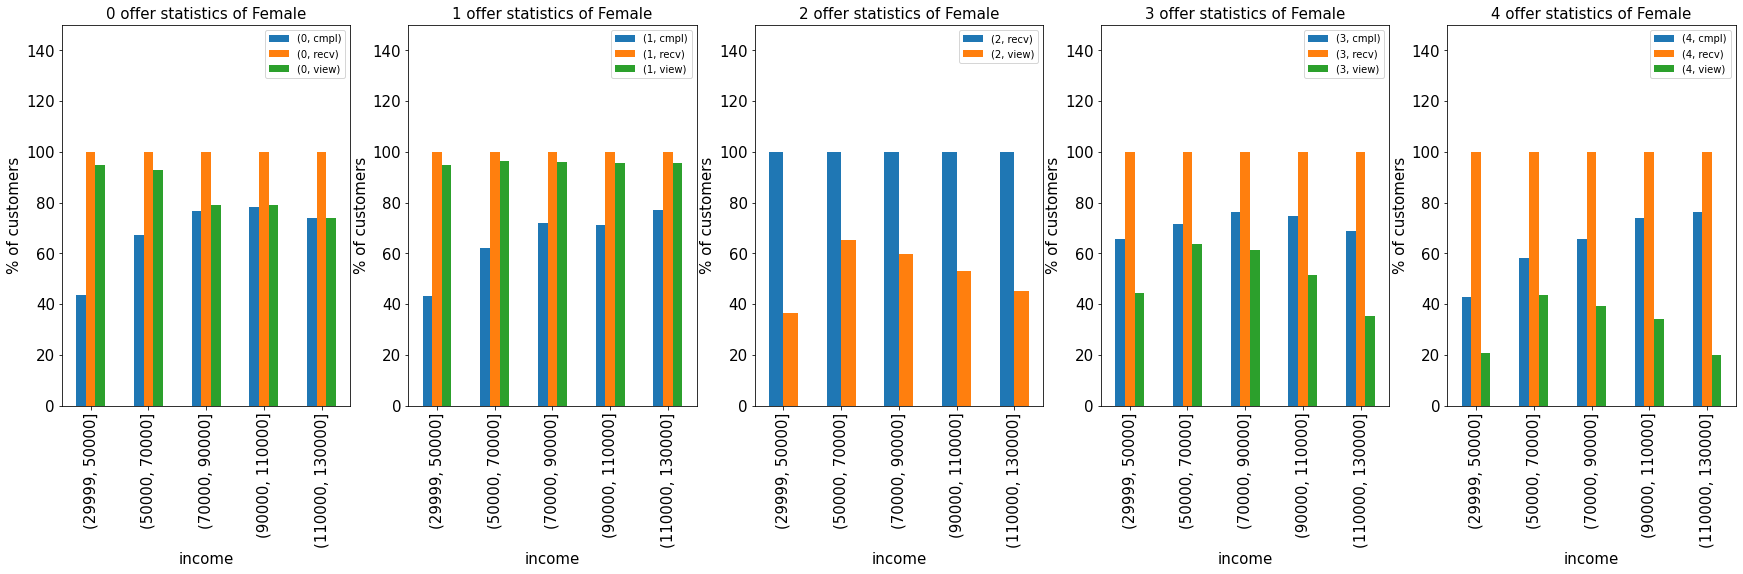

In [49]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i)+' offer statistics of Female',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i,['income'],'F').plot.bar(rot=90,ax=ax)


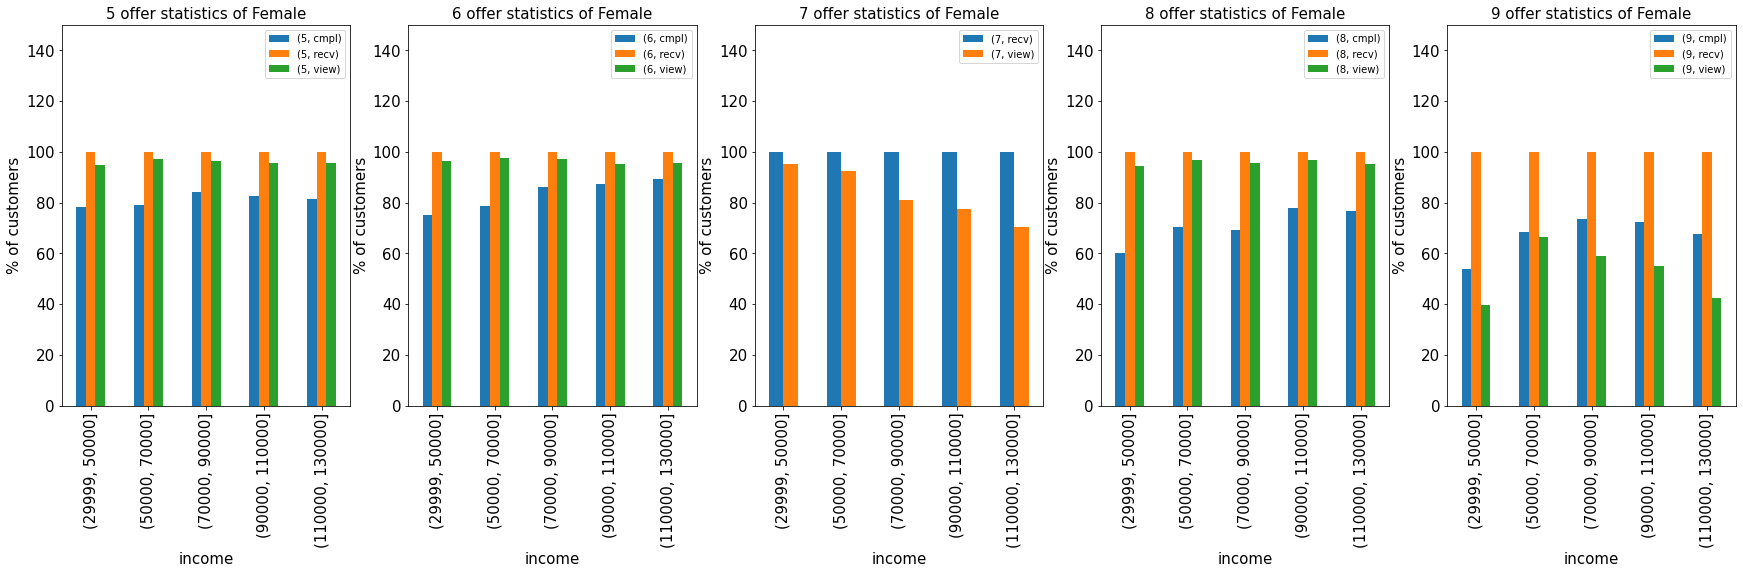

In [50]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i+5)+' offer statistics of Female',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i+5,['income'],'F').plot.bar(rot=90,ax=ax)


#### 4.9.4 Male: income vs completion/view rate

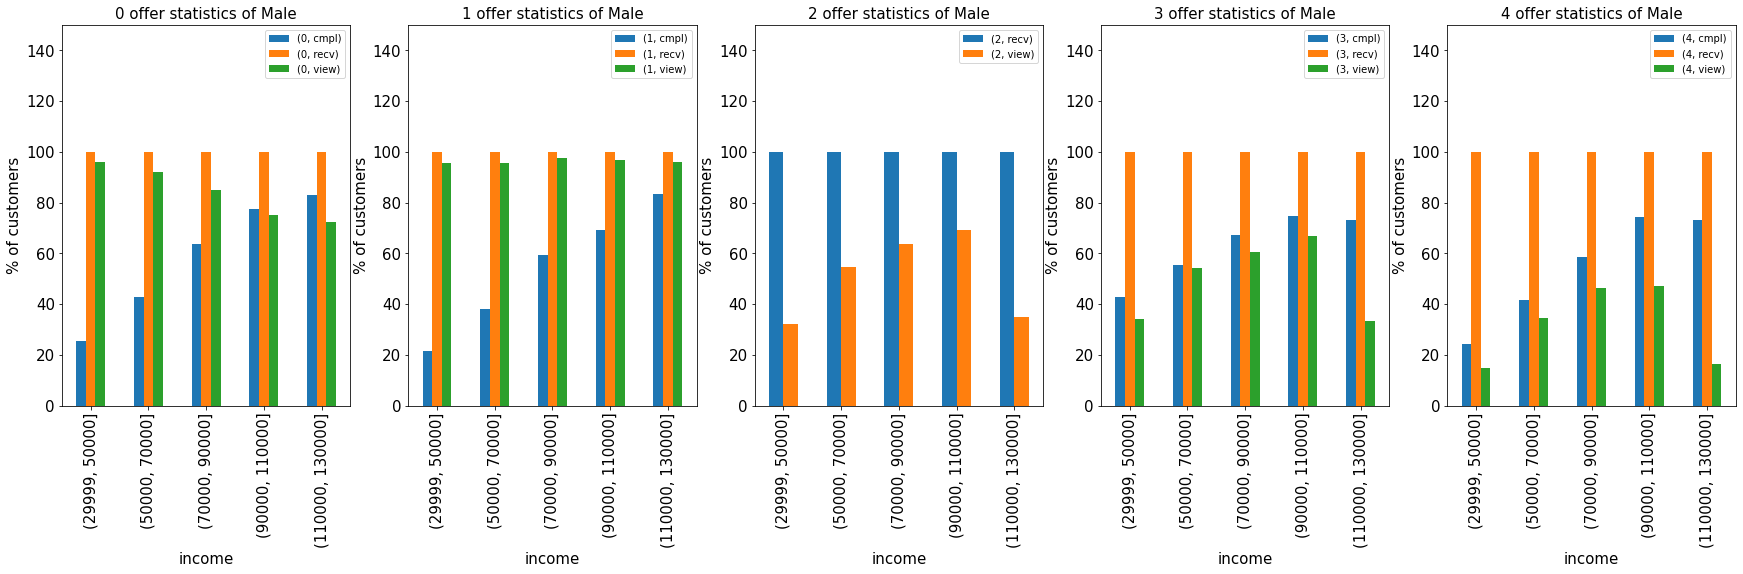

In [51]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i)+' offer statistics of Male',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i,['income'],'M').plot.bar(rot=90,ax=ax)


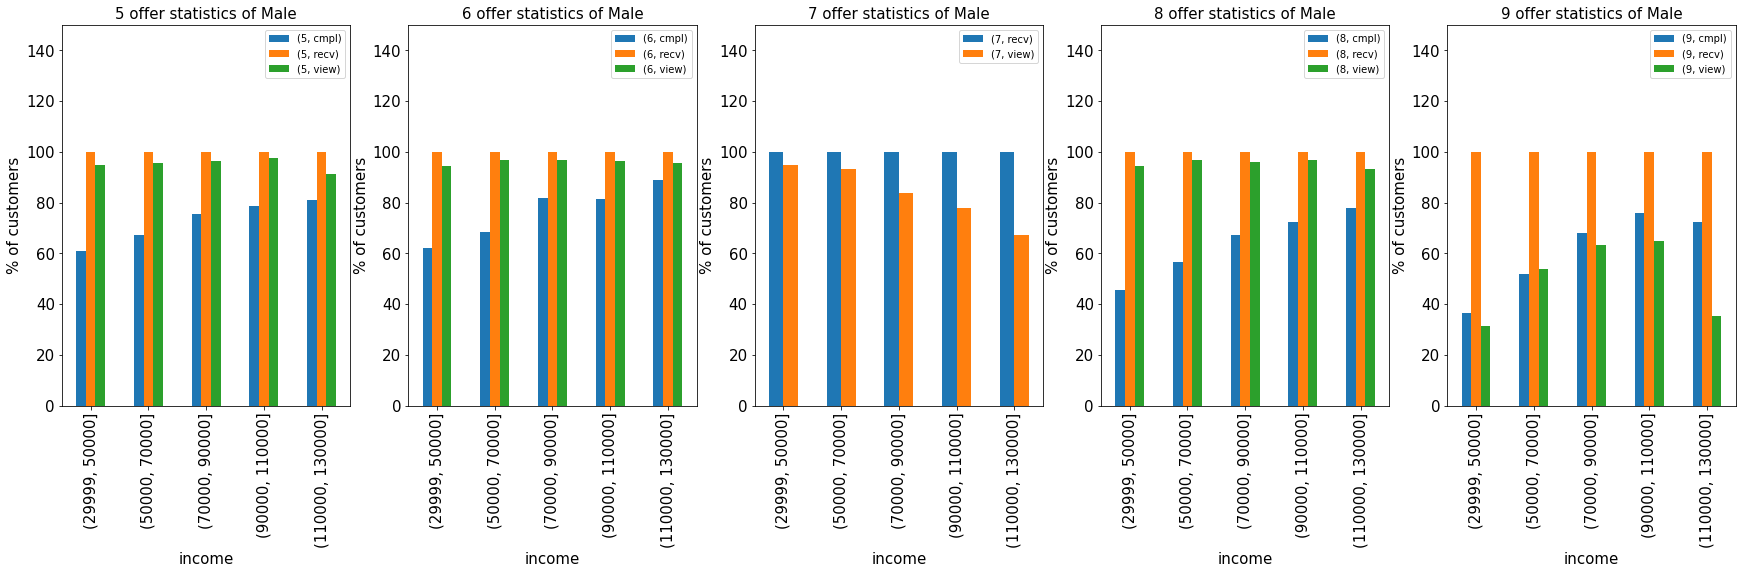

In [52]:
fig, axs = plt.subplots(1,5,figsize=(30,7))
axs=axs.ravel()
for i,ax in enumerate(axs):
    ax.set_title(str(i+5)+' offer statistics of Male',fontsize=15)
    ax.set_ylim(top=150)
    ax.set_ylabel('% of customers',fontsize=15)
    ax.xaxis.get_label().set_fontsize(15)
    ax.yaxis.get_label().set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    customer_profile_stats(profile,offer_stats,i+5,['income'],'M').plot.bar(rot=90,ax=ax)


In [53]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## 5. Main takeaways from data analysis
Based on this study the suggestions to increase the completion, effectiveness of the Starbucks offers strategy are the following:
- Use more social channels to promote the offers
- More focus on young people
- Target more women than men
- Don't send bogo and difficult offers to people with 30000–70000 USD income

## 6. Data modelling

### 6.1 Building feature table / Data processing

In [54]:
### renaming the columns
transcript.rename(columns={'person':'person_id'},inplace=True)
profile.rename(columns={'person':'person_id'},inplace=True)
portfolio.rename(columns={'id': 'offer_id'},inplace=True)

## merging transcipt file with the reward table
feat_table=pd.merge(transcript,reward_table,left_index=True,right_index=True)
feat_table=pd.merge(feat_table,profile,how='left',on='person_id')
## getting dummies for event column and merging the data with portfolio table
feat_table=pd.get_dummies(feat_table,columns=['event'])
feat_table=pd.merge(feat_table,portfolio,how='left',on='offer_id')
feat_table.drop(columns='reward_y',inplace=True)
feat_table.rename(columns={'reward_x': 'reward'},inplace=True)

## getting dummy values for offer_type column
feat_table=pd.get_dummies(feat_table,columns=['offer_type'])
feat_table['offer_id']=feat_table['offer_id'].replace(list(portfolio.offer_id),np.array(portfolio.index))

## getting dummy values for channel column
channels=feat_table['channels'].str.join('|').str.get_dummies()
feat_table=pd.merge(feat_table,channels,left_index=True,right_index=True)

feat_table.rename(columns={'offer_type_bogo':'bogo','offer_type_discount':'discount','offer_type_informational':'informational'},inplace=True)
feat_table.rename(columns={'event_offer received':'offer received','event_offer viewed':'offer viewed','event_offer completed':'offer completed',
'event_transaction':'transaction'},inplace=True)
## taking only year from column 'became_membet_on' and getting dummies for it. 
## getting dummies for gender column 
feat_table['became_member_on']=feat_table.became_member_on.dt.year
feat_table=pd.get_dummies(feat_table,columns=['gender'])
feat_table=pd.get_dummies(feat_table,columns=['became_member_on'])


In [55]:
len(feat_table),len(transcript)

(272762, 272762)

### 6.2 Feature engineering

In [56]:
totals_per_id

,offer completed,offer received,offer viewed,transaction,amount,reward
person,,,,,,
0009655768c64bdeb2e877511632db8f,3.0,5.0,4.0,8.0,127.60,9.0
0011e0d4e6b944f998e987f904e8c1e5,3.0,5.0,5.0,5.0,79.46,13.0
0020c2b971eb4e9188eac86d93036a77,3.0,5.0,3.0,8.0,196.86,14.0
0020ccbbb6d84e358d3414a3ff76cffd,3.0,4.0,4.0,12.0,154.05,13.0
003d66b6608740288d6cc97a6903f4f0,3.0,5.0,4.0,18.0,48.34,9.0
...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,3.0,6.0,3.0,11.0,580.98,9.0
fff7576017104bcc8677a8d63322b5e1,3.0,5.0,4.0,6.0,29.94,9.0
fff8957ea8b240a6b5e634b6ee8eafcf,0.0,3.0,2.0,5.0,12.15,0.0


In [57]:
### making extra feature: average spending per transaction
totals_per_id.reset_index(inplace=True)
totals_per_id['avg_spend']=totals_per_id.amount/totals_per_id.transaction
totals_per_id['avg_reward']=totals_per_id.reward/(totals_per_id['offer completed'])
extra_feat=totals_per_id[['person','avg_spend','avg_reward']]

In [58]:
extra_feat.rename(columns={'person':'person_id'},inplace=True)
extra_feat.head()


/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,person_id,avg_spend,avg_reward
0,0009655768c64bdeb2e877511632db8f,15.950000,3.000000
1,0011e0d4e6b944f998e987f904e8c1e5,15.892000,4.333333
2,0020c2b971eb4e9188eac86d93036a77,24.607500,4.666667
3,0020ccbbb6d84e358d3414a3ff76cffd,12.837500,4.333333
4,003d66b6608740288d6cc97a6903f4f0,2.685556,3.000000


In [59]:
feat_table=pd.merge(feat_table,extra_feat,how='left',on='person_id')

In [60]:
feat_table.head()

,person_id,value,time,amount,offer_id,reward,age,income,offer completed,offer received,...,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018,avg_spend,avg_reward
0,78afa995795e4d85b5d9ceeca43f5fef,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,3.0,NaN,75,100000.0,0,1,...,0,0,0,0,0,0,1,0,22.752857,6.666667
1,e2127556f4f64592b11af22de27a7932,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,9.0,NaN,68,70000.0,0,1,...,1,0,0,0,0,0,0,1,19.243333,3.500000
2,389bc3fa690240e798340f5a15918d5c,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,NaN,8.0,NaN,65,53000.0,0,1,...,1,0,0,0,0,0,0,1,12.143333,3.800000
3,2eeac8d8feae4a8cad5a6af0499a211d,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,NaN,2.0,NaN,58,51000.0,0,1,...,1,0,0,0,0,0,1,0,3.905000,2.000000
4,aa4862eba776480b8bb9c68455b8c2e1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,4.0,NaN,61,57000.0,0,1,...,0,0,0,0,0,0,1,0,14.258333,8.333333


In [61]:
## removing redundant 
feat_table.drop(columns=['value','channels'],inplace=True)

In [62]:
feat_table.columns

Index(['person_id', 'time', 'amount', 'offer_id', 'reward', 'age', 'income',
       'offer completed', 'offer received', 'offer viewed', 'transaction',
       'difficulty', 'duration', 'bogo', 'discount', 'informational', 'email',
       'mobile', 'social', 'web', 'gender_F', 'gender_M', 'gender_O',
       'became_member_on_2013', 'became_member_on_2014',
       'became_member_on_2015', 'became_member_on_2016',
       'became_member_on_2017', 'became_member_on_2018', 'avg_spend',
       'avg_reward'],
      dtype='object')

In [63]:
feat_table.isnull().sum()

person_id                     0
time                          0
amount                   148805
offer_id                 123957
reward                   240318
age                           0
income                        0
offer completed               0
offer received                0
offer viewed                  0
transaction                   0
difficulty               123957
duration                 123957
bogo                          0
discount                      0
informational                 0
email                         0
mobile                        0
social                        0
web                           0
gender_F                      0
gender_M                      0
gender_O                      0
became_member_on_2013         0
became_member_on_2014         0
became_member_on_2015         0
became_member_on_2016         0
became_member_on_2017         0
became_member_on_2018         0
avg_spend                  2617
avg_reward                33495
dtype: i

### 6.3 Dealing with missing values:
1. offer_id drop values
2. remove amount and reward columns
3. fill nan with 0 in avg_spend and avg_reward

In [64]:
feat_table.drop(columns=['reward','amount'],inplace=True)
feat_table.drop(feat_table[feat_table.offer_id.isnull()].index,inplace=True)
feat_table.fillna(0.0,inplace=True)

In [65]:
feat_table.isnull().sum()

person_id                0
time                     0
offer_id                 0
age                      0
income                   0
offer completed          0
offer received           0
offer viewed             0
transaction              0
difficulty               0
duration                 0
bogo                     0
discount                 0
informational            0
email                    0
mobile                   0
social                   0
web                      0
gender_F                 0
gender_M                 0
gender_O                 0
became_member_on_2013    0
became_member_on_2014    0
became_member_on_2015    0
became_member_on_2016    0
became_member_on_2017    0
became_member_on_2018    0
avg_spend                0
avg_reward               0
dtype: int64

## 6.4 Metrics to evaluate the model
Since dataset classes are imbalanced, sensitivity (true positive rate) and specificity (true negative rate) is taken into account to evaluate the model performance.

In [68]:
feat_table['offer viewed'].value_counts(),feat_table['offer completed'].value_counts()

(0    98945
 1    49860
 Name: offer viewed, dtype: int64,
 0    116361
 1     32444
 Name: offer completed, dtype: int64)

### 6.5 Test different classification algorithms
1. Naive Bayes Classifier 
2. Logistic Regression Classifier  
3. K-nearest neighbours 

In [69]:
def X_Y (param):
    
    if param == 'completed':
        
        data = feat_table[feat_table.informational == 0]
        
        X = data[['time','age', 'income', 'avg_spend','avg_reward',
       'difficulty', 'duration', 'bogo', 'discount', 'email',
       'mobile', 'social', 'web', 'gender_F', 'gender_M', 'gender_O',
       'became_member_on_2013', 'became_member_on_2014',
       'became_member_on_2015', 'became_member_on_2016',
       'became_member_on_2017', 'became_member_on_2018','offer received','offer viewed']]
        
        y = data['offer completed']
        
    if param == 'viewed':
        
        X = feat_table[['time', 'age', 'income', 'avg_spend','avg_reward',
       'difficulty', 'duration', 'bogo', 'discount', 'informational', 'email',
       'mobile', 'social', 'web', 'gender_F', 'gender_M', 'gender_O',
       'became_member_on_2013', 'became_member_on_2014',
       'became_member_on_2015', 'became_member_on_2016',
       'became_member_on_2017', 'became_member_on_2018','offer received']]
        
        y = feat_table['offer viewed']
        
    return X,y   

In [70]:
X,y=X_Y('viewed')

In [71]:
X.head()

,time,age,income,avg_spend,avg_reward,difficulty,duration,bogo,discount,informational,...,gender_F,gender_M,gender_O,became_member_on_2013,became_member_on_2014,became_member_on_2015,became_member_on_2016,became_member_on_2017,became_member_on_2018,offer received
0,0,75,100000.0,22.752857,6.666667,5.0,7.0,1,0,0,...,1,0,0,0,0,0,0,1,0,1
1,0,68,70000.0,19.243333,3.500000,10.0,7.0,0,1,0,...,0,1,0,0,0,0,0,0,1,1
2,0,65,53000.0,12.143333,3.800000,5.0,5.0,1,0,0,...,0,1,0,0,0,0,0,0,1,1
3,0,58,51000.0,3.905000,2.000000,0.0,4.0,0,0,1,...,0,1,0,0,0,0,0,1,0,1
4,0,61,57000.0,14.258333,8.333333,20.0,10.0,0,1,0,...,1,0,0,0,0,0,0,1,0,1


In [72]:
X.shape,y.shape

((148805, 24), (148805,))

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11)
X_train.columns

Index(['time', 'age', 'income', 'avg_spend', 'avg_reward', 'difficulty',
       'duration', 'bogo', 'discount', 'informational', 'email', 'mobile',
       'social', 'web', 'gender_F', 'gender_M', 'gender_O',
       'became_member_on_2013', 'became_member_on_2014',
       'became_member_on_2015', 'became_member_on_2016',
       'became_member_on_2017', 'became_member_on_2018', 'offer received'],
      dtype='object')

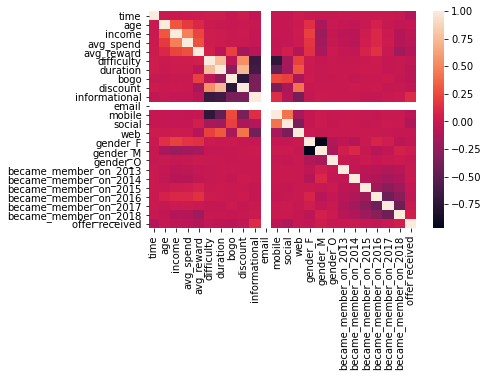

In [74]:
sns.heatmap(X.corr(),xticklabels=True, yticklabels=True)
plt.show()

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


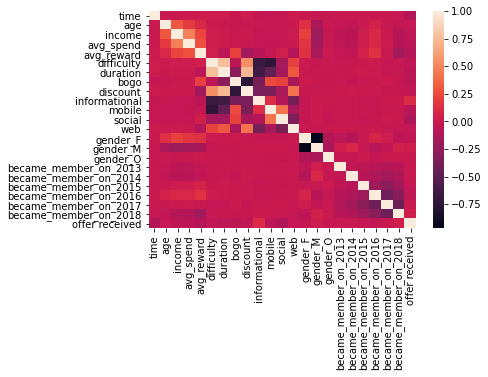

In [75]:
## drop email column to remove Danish flag effect
X.drop(columns=['email'],inplace=True)
sns.heatmap(X.corr(),xticklabels=True, yticklabels=True)
plt.show()

In [76]:
accuracy={}
for i in ['viewed','completed']:
    X,y = X_Y(i)
    X.drop(columns=['email'],inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=11)
    accuracy[i+' Accuracy']=[]
    accuracy[i+' Sensitivity']=[]
    accuracy[i+' Specificity']=[]
    accuracy[i+' Precision']=[]
    accuracy[i+' Negative Predictive Value']=[]
    
    for classifier in [GaussianNB(),LogisticRegression(solver='liblinear'),KNeighborsClassifier(n_neighbors=5)]:
        model = classifier.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        tn, fp, fn, tp=confusion_matrix(y_test,y_pred).ravel()
        accuracy[i+' Accuracy'].append((tp+tn)/(tp+tn+fp+fn))
        accuracy[i+' Sensitivity'].append(tp/(tp+fn))
        accuracy[i+' Specificity'].append(tn/(tn+fp))
        accuracy[i+' Precision'].append(tp/(tp+fp))
        accuracy[i+' Negative Predictive Value'].append(tn/(tn+fn))    
    

<ipython-input-76-1f4d544b9a3d>:19: RuntimeWarning: invalid value encountered in long_scalars
  accuracy[i+' Precision'].append(tp/(tp+fp))


### 6.6 Results

In [77]:
accuracy

{'viewed Accuracy': [0.7867674011322445,
  0.6656824013358856,
  0.6968394900826783],
 'viewed Sensitivity': [0.5276847170615825, 0.0, 0.3588353535968813],
 'viewed Specificity': [0.9168833552571202, 1.0, 0.8665912080516381],
 'viewed Precision': [0.7612478031634446, nan, 0.5746195864221615],
 'viewed Negative Predictive Value': [0.7944653554577745,
  0.6656824013358856,
  0.7290883821485561],
 'completed Accuracy': [0.8592053425578937,
  0.7371000288267512,
  0.7679446526376478],
 'completed Sensitivity': [0.5049725810948973,
  0.014127707035969885,
  0.44585928060228647],
 'completed Specificity': [0.9826686967507856,
  0.9890828987009621,
  0.8802034403446823],
 'completed Precision': [0.9103552278820375,
  0.310838445807771,
  0.5646851088875809],
 'completed Negative Predictive Value': [0.8506449803701627,
  0.7421668003597559,
  0.8200585518969004]}

In [82]:
accuracy['method']= ['Gaussian','Logistic','KNeigh']

In [83]:
final_result=pd.DataFrame(accuracy)
final_result

,viewed Accuracy,viewed Sensitivity,viewed Specificity,viewed Precision,viewed Negative Predictive Value,completed Accuracy,completed Sensitivity,completed Specificity,completed Precision,completed Negative Predictive Value,method
0,0.786767,0.527685,0.916883,0.761248,0.794465,0.859205,0.504973,0.982669,0.910355,0.850645,Gaussian
1,0.665682,0.000000,1.000000,NaN,0.665682,0.737100,0.014128,0.989083,0.310838,0.742167,Logistic
2,0.696839,0.358835,0.866591,0.574620,0.729088,0.767945,0.445859,0.880203,0.564685,0.820059,KNeigh


In [84]:
final_result[final_result.columns[::-1][:6]]

,method,completed Negative Predictive Value,completed Precision,completed Specificity,completed Sensitivity,completed Accuracy
0,Gaussian,0.850645,0.910355,0.982669,0.504973,0.859205
1,Logistic,0.742167,0.310838,0.989083,0.014128,0.737100
2,KNeigh,0.820059,0.564685,0.880203,0.445859,0.767945


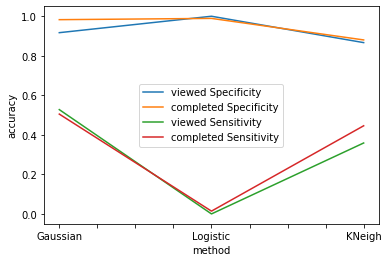

In [86]:
final_result.plot(x='method',y=['viewed Specificity','completed Specificity','viewed Sensitivity','completed Sensitivity'])
plt.ylabel('accuracy')
plt.show()

### 6.6 Data modelling findings
Three classification methods were tried to assess whether customer views/completes the offer. The selected algorithms are the following:
- Gaussian (Naive Bayes), which is used based on the assumption that all the features are independent
- Logistic regression, which is utilized considering that decision surface linear
- K-Nearest Neighbours, which is applied assuming that there are no outliers.

It turns out that all the classification models have specificity and sensitivity when analyzing offer completion event. General trend shows that Gaussian classifier has the highest perfomance followed by Kneigh and lastly Logistic. This suggest that most of parameters (features) might be independent. Lower Kneigh accuracy might be associated to the outliers present in this data. Lastly, poor performance of Logistic Regression implies that decision surface is not linearly separable and other methods for the classification should be used. 

## 7. Conclusions
Based on this study the suggestions to increase the completion, effectiveness of the Starbucks offers strategy are the following:
- Use more social channels to promote the offers
- More focus on young people
- Target more women than men
- Don't send bogo and difficult offers to people with 30000–70000 USD income

As for data modelling, Gaussian classifier works the best for the given problem. With the given dataset the specificity an sensitivity of 98.2% and 50.4% was achieved,respectively. Superior performance of Gaussian (Naive Bayes) over other classifier implies that most of the features are independent or loosely dependent, which can be seen in the correlation matrix.


## 8. Improvements

The modelling can be improved by more specific feature engineering. Such as, building a feature which provides information about average time between receiving offer and viewing it. On top of that, data scalling/normalization might be considered to improve the model performance. Lastly, model hyperparemeters might be also tuned to achieve higher performance. 
